<a href="https://colab.research.google.com/github/JooyeonK/kakao-analysis/blob/main/XRP_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## Keras usage practice
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)


11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4883 - accuracy: 0.8589
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1497 - accuracy: 0.9549
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1083 - accuracy: 0.9673
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0890 - accuracy: 0.9731
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.0774 - accuracy: 0.9753


[0.07741659879684448, 0.9753000140190125]

암호화폐의 한 종류인 리플(XRP)의 가격 급등(시초가와 고가 차이가 5% 이상) 여부를 예측하는 코드 짜기

- 사용 알고리즘 - 랜덤 포레스트
- 데이터 - 리플(XRP)의 1시간 단위 가격 정보 (출처 - 빗썸 Bithumb)
- 변수(feature) - 시초가, 종가, 고가, 저가, 갭(아래에서 정의), 트렌드(아래에서 정의), 해당 시간 급등 여부
- 라벨(target) - 이후 5시간 이내에 급등이 존재함(1), 존재하지 않음(0)

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Bithumb_XRPKRW_1h.csv to Bithumb_XRPKRW_1h.csv


In [5]:
import io
xrp = pd.read_csv(io.BytesIO(uploaded['Bithumb_XRPKRW_1h.csv']), skiprows = 1)

In [6]:
xrp.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume XRP,Volume KRW
0,1.605856e+09,2020-11-20 07-AM,XRPKRW,334.1,334.9,332.2,333.1,4064148.25,1.354794e+09
1,1.605852e+09,2020-11-20 06-AM,XRPKRW,332.0,334.6,331.7,334.1,4450924.10,1.484007e+09
2,1.605848e+09,2020-11-20 05-AM,XRPKRW,335.2,335.7,329.5,332.0,8316327.40,2.759482e+09
3,1.605845e+09,2020-11-20 04-AM,XRPKRW,335.0,336.2,333.0,335.2,4461271.49,1.491363e+09
4,1.605841e+09,2020-11-20 03-AM,XRPKRW,337.4,337.8,334.7,335.0,3636048.86,1.223512e+09


In [7]:
xrp["Soar"] = [int(a) for a in xrp["High"]/xrp["Open"] > 1.05]
xrp["Gap"] = (xrp["High"] - xrp["Low"])/xrp["Open"]
## 고가와 저가의 차이를 시초가로 나누어 scaling 한 것을 gap이라고 정의한다.
xrp.head(10)

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume XRP,Volume KRW,Soar,Gap
0,1.605856e+09,2020-11-20 07-AM,XRPKRW,334.1,334.9,332.2,333.1,4064148.25,1.354794e+09,0,0.008081
1,1.605852e+09,2020-11-20 06-AM,XRPKRW,332.0,334.6,331.7,334.1,4450924.10,1.484007e+09,0,0.008735
2,1.605848e+09,2020-11-20 05-AM,XRPKRW,335.2,335.7,329.5,332.0,8316327.40,2.759482e+09,0,0.018496
3,1.605845e+09,2020-11-20 04-AM,XRPKRW,335.0,336.2,333.0,335.2,4461271.49,1.491363e+09,0,0.009552
4,1.605841e+09,2020-11-20 03-AM,XRPKRW,337.4,337.8,334.7,335.0,3636048.86,1.223512e+09,0,0.009188
5,1.605838e+09,2020-11-20 02-AM,XRPKRW,336.0,338.6,335.5,337.4,5537214.68,1.866672e+09,0,0.009226
6,1.605834e+09,2020-11-20 01-AM,XRPKRW,335.5,336.2,334.6,336.0,3041073.92,1.020078e+09,0,0.004769
7,1.605830e+09,2020-11-20 12-AM,XRPKRW,337.7,337.7,334.3,335.5,10067769.60,3.387677e+09,0,0.010068
8,1.605827e+09,2020-11-19 11-PM,XRPKRW,334.7,337.8,332.9,337.7,6555515.08,2.195813e+09,0,0.014640
9,1.605823e+09,2020-11-19 10-PM,XRPKRW,331.9,335.5,331.0,334.7,2692570.25,8.989558e+08,0,0.013558


In [8]:
def trend(nrow):
  if nrow > xrp.shape[0] - 5 :
    return None
  else:
    aa = xrp["Gap"][(nrow+1):(nrow+5)]
    avg = np.mean(aa)
  return avg

def willsoar(nrow):
  if nrow < 5 :
    return None
  else:
    aa = xrp["Soar"][(nrow - 5):(nrow-1)]
    yes = sum(aa) > 0
    return yes

tr = []
ws = []
for i in range(xrp.shape[0]):
  tr.append(trend(i))
  ws.append(willsoar(i))

tr[:10]
# 특정 시간의 직전 5시간 동안 gap의 평균을 trend라고 정의한다. rough하게 말하면 절대편차의 평균이므로 분산과 비슷한 값이라고 생각할 수 있다.
# trend는 가격의 fluctuation이 심했는지 아니면 거의 변동이 없었는지를 나타내 주는 변수.

ws[:10]
# 특정 시간의 직후 5시간 내에 급등 (시초가로부터 5% 이상의 가격 상승)이 존재하는지를 나타내는 변수이다.
# 본 프로젝트의 target.

[None, None, None, None, None, False, False, False, False, False]

In [9]:
xrp["Trend"] = tr
xrp["WillSoar"] = ws
xrp.head(15)


,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume XRP,Volume KRW,Soar,Gap,Trend,WillSoar
0,1.605856e+09,2020-11-20 07-AM,XRPKRW,334.1,334.9,332.2,333.1,4064148.25,1.354794e+09,0,0.008081,0.011493,None
1,1.605852e+09,2020-11-20 06-AM,XRPKRW,332.0,334.6,331.7,334.1,4450924.10,1.484007e+09,0,0.008735,0.011616,None
2,1.605848e+09,2020-11-20 05-AM,XRPKRW,335.2,335.7,329.5,332.0,8316327.40,2.759482e+09,0,0.018496,0.008184,None
3,1.605845e+09,2020-11-20 04-AM,XRPKRW,335.0,336.2,333.0,335.2,4461271.49,1.491363e+09,0,0.009552,0.008313,None
4,1.605841e+09,2020-11-20 03-AM,XRPKRW,337.4,337.8,334.7,335.0,3636048.86,1.223512e+09,0,0.009188,0.009676,None
5,1.605838e+09,2020-11-20 02-AM,XRPKRW,336.0,338.6,335.5,337.4,5537214.68,1.866672e+09,0,0.009226,0.010759,False
6,1.605834e+09,2020-11-20 01-AM,XRPKRW,335.5,336.2,334.6,336.0,3041073.92,1.020078e+09,0,0.004769,0.012927,False
7,1.605830e+09,2020-11-20 12-AM,XRPKRW,337.7,337.7,334.3,335.5,10067769.60,3.387677e+09,0,0.010068,0.013110,False
8,1.605827e+09,2020-11-19 11-PM,XRPKRW,334.7,337.8,332.9,337.7,6555515.08,2.195813e+09,0,0.014640,0.012228,False
9,1.605823e+09,2020-11-19 10-PM,XRPKRW,331.9,335.5,331.0,334.7,2692570.25,8.989558e+08,0,0.013558,0.011322,False


이 프로젝트를 시작하게 된 계기는 경험적인 궁금증이다. 재미삼아 가상화폐 계좌를 만들고, 투자를 하다 보니 "일정 시간 동안 가격이 별로 움직이지 않던 화폐를 사면 머지않아 그 코인 가격이 급등한다"는 것을 느끼게 되었다. 그냥 느낌이 그런지, 아니면 실제로 이 "적은 가격 변동"이라는 변수가 급등 여부 예측에 도움이 되는 건지를 알아보고자 이 프로젝트를 시작했다. 

In [10]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'Trend')

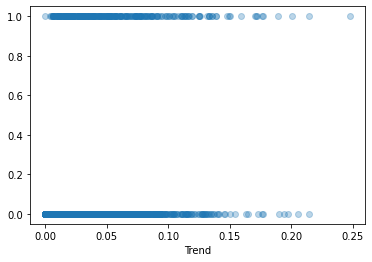

In [13]:
## visualization - does small variation indicate future soar?

plt.scatter(x = xrp_clean["Trend"], y = xrp_clean["Soar"], alpha = 0.3)
plt.xlabel("Trend")

이 스캐터플롯은 별로 좋은 인사이트를 주지 못한다... 급등이 없는 (0) observation의 trend와 급등이 존재하는(1) observation의 trend가 크게 다르지 않아 보인다.

In [16]:
xrp_clean.groupby("Soar").mean()

,Unix Timestamp,Open,High,Low,Close,Volume XRP,Volume KRW,Gap,Trend
Soar,,,,,,,,,
0,1.556554e+09,469.556916,472.743535,465.458534,468.826965,3.781497e+06,2.105158e+09,0.011600,0.012037
1,1.526574e+09,1104.576490,1200.435099,1093.360265,1171.303642,1.927474e+07,1.519614e+10,0.095079,0.055633


급등이 존재하는 데이터의 Trend가 더 큰 것을 볼 수 있다. 이것은 오히려 내가 생각했던 가설과 반대이다. 이 결과가 함의하는 것은, "직전에 변동성이 컸던 경우, 해당 시간에도 급등이 일어날 가능성이 높다" 정도가 되겠다.

In [12]:
n = xrp.shape[0]
xrp_clean = xrp[5:(n-5)]
y = [int(x) for x in xrp_clean["WillSoar"]]
X = xrp_clean[["Open", "High", "Low", "Close", "Gap", "Trend", "Soar"]]

# Predict if there will be a soar within 5 hours

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [ ]:
import seaborn as sns

Accuracy score = 0.9688


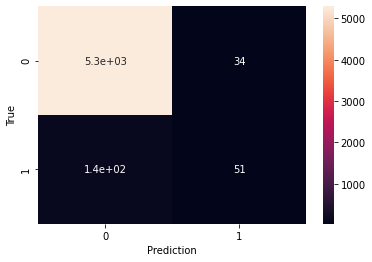

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(max_depth = 100, random_state = 1)
rf.fit(X_train, y_train)
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print("Accuracy score = {}".format(round(accuracy, 4)))

cm = pd.DataFrame(confusion_matrix(y_test, predicted))
ax = sns.heatmap(cm, annot=True)
ax.set(xlabel = "Prediction", ylabel = "True")
plt.show()

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("Precision = {}".format(precision_score(y_test, predicted)))
print("Recall = {}".format(recall_score(y_test, predicted)))
print(n)
print(sum(y))
print("Proportion of soar = {} %".format(round(sum(y)/n*100, 3)))

Precision = 0.6
Recall = 0.2698412698412698
27573
922
Proportion of soar = 3.344 %


Accuracy는 96.88% 로 매우 높은 것에 비하여 Precision과 Recall은 각각 60%, 27%로 좋지 않다. 이는 데이터셋이 매우 치우쳐 있기 때문이다. 전체 데이터 27573건 중 급등이 발생하는 데이터는 922건으로, 약 3.3퍼센트에 그친다. 이는 쉽게 말해서 Classifier가 feature들을 전혀 보지 않고 무조건 0으로 predict해도 accuracy가 97%에 달한다는 의미이다. 이처럼, 의미있는 분류기를 만들려면 imbalanced data를 handle할 방법이 필요하다.

우리의 imbalanced data에는 "1"이 3퍼센트, "0"이 97퍼센트 존재한다. 이 편향을 완화하기 위해서 취할 수 있는 방식은 크게 두 가지가 있다. undersampling과 oversampling이다.
1. Undersampling
- 너무 많은 쪽의 데이터를 랜덤하게 일부분만 뽑아서 새로운 작은 dataset을 만드는 방법
2. Oversampling
- 적은 쪽의 데이터에서 복원추출을 통해 dataset의 크기를 키우는 방법
- SMOTE 방법이 많이 쓰임

자세한 내용은 아래의 블로그에 설명되어 있다.

출처: https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/

In [ ]:
# Try oversampling
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
overX, overy = oversample.fit_resample(X, y)

print("number of soar: {} -> {}".format(sum(y), sum(overy)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


number of soar: 922 -> 26641


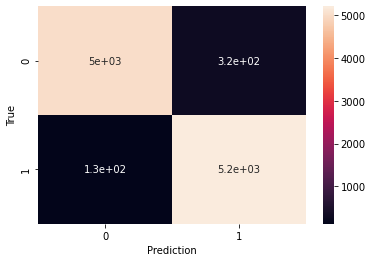

In [ ]:
trainosX, testosX, trainosy, testosy = train_test_split(overX, overy, test_size = 0.2, random_state = 33)
rfsmote = RandomForestClassifier()
rfsmote.fit(trainosX, trainosy)
smotepred = rfsmote.predict(testosX)

cm2 = pd.DataFrame(confusion_matrix(testosy, smotepred))
ax2 = sns.heatmap(cm2, annot=True)
ax2.set(xlabel = "Prediction", ylabel = "True")
plt.show()

precision과 recall을 계산해보자.

In [ ]:
print("Precision = {}".format(precision_score(testosy, smotepred)))
print("Recall = {}".format(recall_score(testosy, smotepred)))

Precision = 0.9421996738539591
Recall = 0.975609756097561


Precision 94%, Recall 98%이라는 훌륭한 결과가 나왔다. 이 분류기를 이용하는 사람 입장에서는 Precision이 더 중요하게 여겨질 것이다. 데이터를 넣었을 때 급등한다고 예측되는 데이터의 94%가 실제로 급등하기 때문이다.

이제, 이 분류기가 어떤 기준으로 분류를 하는지 살펴보자.